In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import pandas as pd

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
next(iter(training_data))[0].size()

torch.Size([1, 28, 28])

In [21]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.fc = nn.Linear(7 * 7 * 32, 10)
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 32, 700),
            nn.Linear(700, 300),
            nn.Linear(300, 100),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to('cuda')
        y = y.to('cuda')
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss += loss
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    average_loss = train_loss / (size // 100 + 1)
    return average_loss

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_loss = test_loss / num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {average_loss:>8f} \n")

    return average_loss

In [23]:
learning_rate = 1e-3
batch_size = 64

In [24]:
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [25]:
epochs = 20
train_loss_list = []
test_loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_list.append(train_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311959  [    0/60000]
loss: 0.451197  [ 6400/60000]
loss: 0.281045  [12800/60000]
loss: 0.528771  [19200/60000]
loss: 0.553415  [25600/60000]
loss: 0.487223  [32000/60000]
loss: 0.276056  [38400/60000]
loss: 0.524556  [44800/60000]
loss: 0.451194  [51200/60000]
loss: 0.330268  [57600/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.395551 

Epoch 2
-------------------------------
loss: 0.244701  [    0/60000]
loss: 0.339198  [ 6400/60000]
loss: 0.201216  [12800/60000]
loss: 0.435096  [19200/60000]
loss: 0.390057  [25600/60000]
loss: 0.394771  [32000/60000]
loss: 0.246422  [38400/60000]
loss: 0.389509  [44800/60000]
loss: 0.288344  [51200/60000]
loss: 0.314216  [57600/60000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.347319 

Epoch 3
-------------------------------
loss: 0.173604  [    0/60000]
loss: 0.344587  [ 6400/60000]
loss: 0.183060  [12800/60000]
loss: 0.350025  [19200/60000]
loss: 0.350563  [25600/60000]
loss: 0.390428  [32000/600

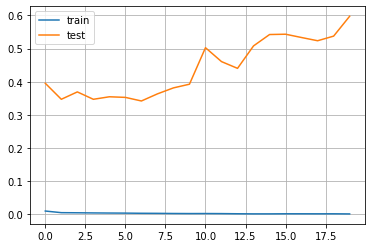

In [27]:
pd.DataFrame(dict(train=train_loss_list, test=test_loss_list)).plot(grid=True)